In [1]:
# Source:
# http://blog.nextgenetics.net/?e=102
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
body {background-color: rgba(192, 255, 238, 0.3) !important;}
</style>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# Initialize the environment
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
sns.set(style="darkgrid")

In [3]:
sales = pd.read_csv(
    "https://raw.githubusercontent.com/rjstange/video-game-sales-by-rating/master/Video_Games_Sales_as_at_22_Dec_2016.csv"
)

In [4]:
na_sales_e_to_m_since_2003 = sales.loc[  # Only pull from entries 
    (sales["NA_Sales"] > 0)  # Where there are US sales
    & sales.Rating.notnull()  # Where there is a rating
    & (sales["Rating"] != "AO")  # Excluding limited observations
    & (sales["Rating"] != "EC")
    & (sales["Year_of_Release"] >= 2003),  # Released in 2003+
    [
        "Name",
        "Genre",
        "Year_of_Release",
        "NA_Sales",
        "Rating",
    ],
]

In [104]:
def pointplot(xarray, yarray, df, xorder):
    sns.set(
        rc={"figure.figsize": (30, 20)}  # Set figure size
    )  
    ax = sns.pointplot(
        x=xarray,
        y=yarray,
        data=df,
        join=False,
        order=xorder,
        scale=2,
    )           # Format yticks to be in hundreds of thousands
    ylabels = ['{:,.0f}K'.format(y) for y in ax.get_yticks() * 1000]
    ax.set_yticklabels(ylabels)
    sns.set_context("talk")        # Make it more presentable
    plt.xlabel("\n{}\n".format(xarray), fontsize=30)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=20)
    plt.ylabel("Sales\n", fontsize=30)
    plt.title("\nUnits Sold\n", fontsize=42, fontweight=600);

# US Video Game Sales in Relation to Maturity Rating and Genre
## Riley Stange
### October 8, 2019

- Does a Video Game's maturity rating impact sales?

- Does the genre have an impact as well?

- If so, by how much on average?

<h2><center>Understanding ESRB's Ratings</center></h2>

<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/E.svg" width="100" height="170" /><br>Content is generally suitable for all ages. May contain minimal cartoon, fantasy or mild violence and/or infrequent use of mild language<br>
<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/E10plus.svg" width="100" height="170" /><br>Content is generally suitable for ages 10 and up. May contain more cartoon, fantasy or mild violence, mild language and/or minimal suggestive themes.

<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/T.svg" width="100" height="170" /><br>Content is generally suitable for ages 13 and up. May contain violence, suggestive themes, crude humor, minimal blood, simulated gambling and/or infrequent use of strong language.<br>
<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/M.svg" width="100" height="170" /><br>Content is generally suitable for ages 17 and up. May contain intense violence, blood and gore, sexual content and/or strong language.

## Overview: M-Rated Video Games performance in recent years

In [6]:
print(
    na_sales_e_to_m_since_2003["NA_Sales"]
    .groupby(na_sales_e_to_m_since_2003["Rating"])
    .agg("sum")
)

Rating
E       1045.20
E10+     345.50
M        669.38
T        590.91
Name: NA_Sales, dtype: float64


- From 2003-2016, M-Rated Video Games have been #2

- With 669+ million in total number of games sold

- Second only to games of the E-Rating at 1.045 billion

<center><h2>Sales Trends 2003-2016</h2></center>

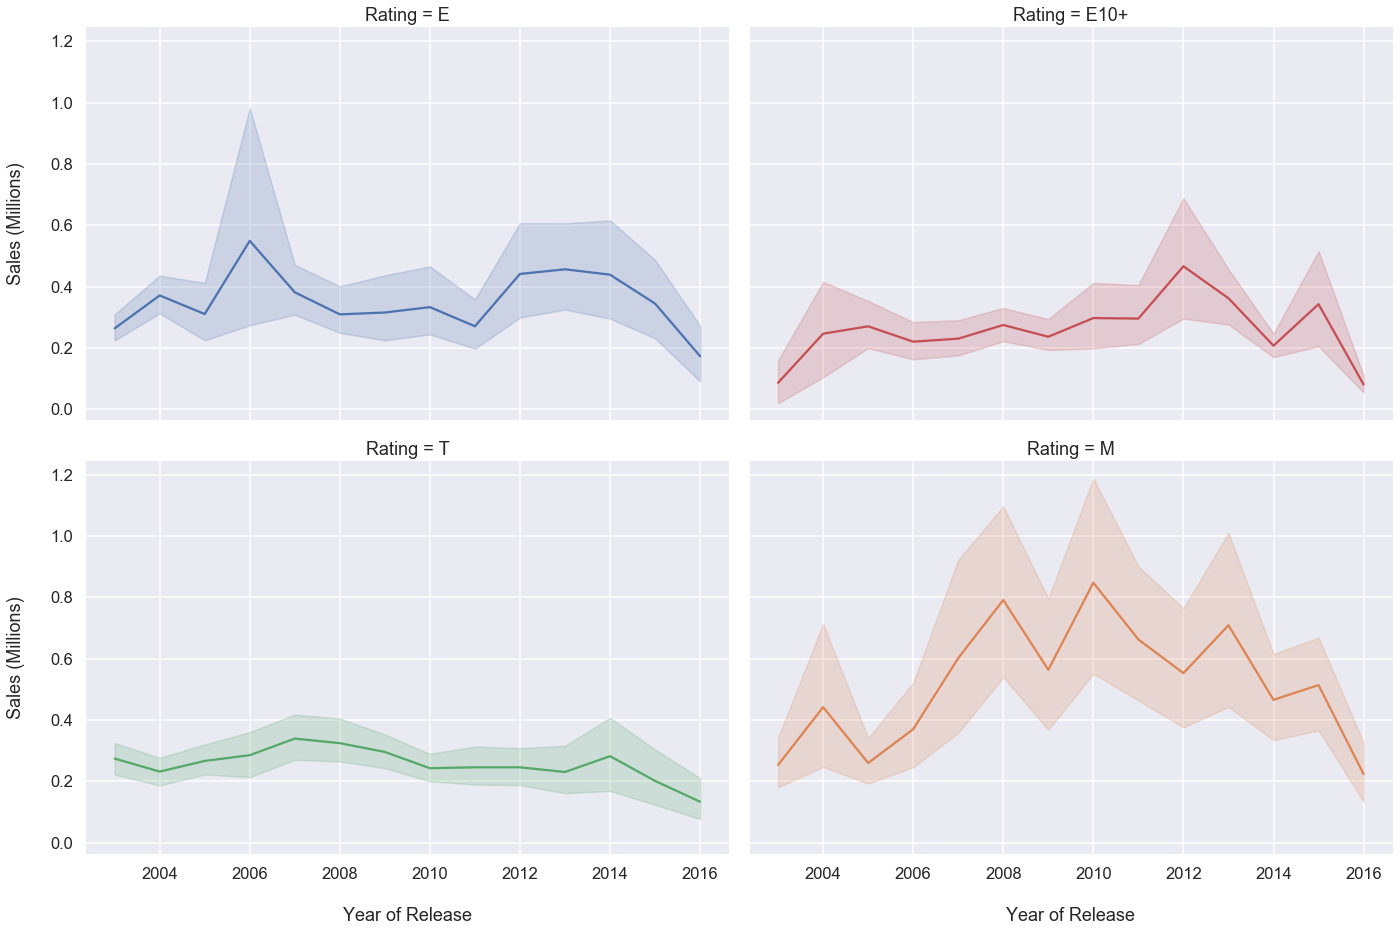

In [110]:
ax = sns.relplot(
    x="Year_of_Release",
    y="NA_Sales",
    hue="Rating",
    col="Rating",
    col_order=["E", "E10+", "T", "M"],
    col_wrap=2,
    height=6.5,
    aspect=1.5,
    kind="line",
    data=na_sales_e_to_m_since_2003,
    legend=False,
)
ax.set(xlabel="\nYear of Release", ylabel="Sales (Millions)\n")
sns.set_context("talk")
plt.show()

- Since 2007 M-Rated games have been dominant in unit sales

- Now, is there a statistically significant difference in average sales?

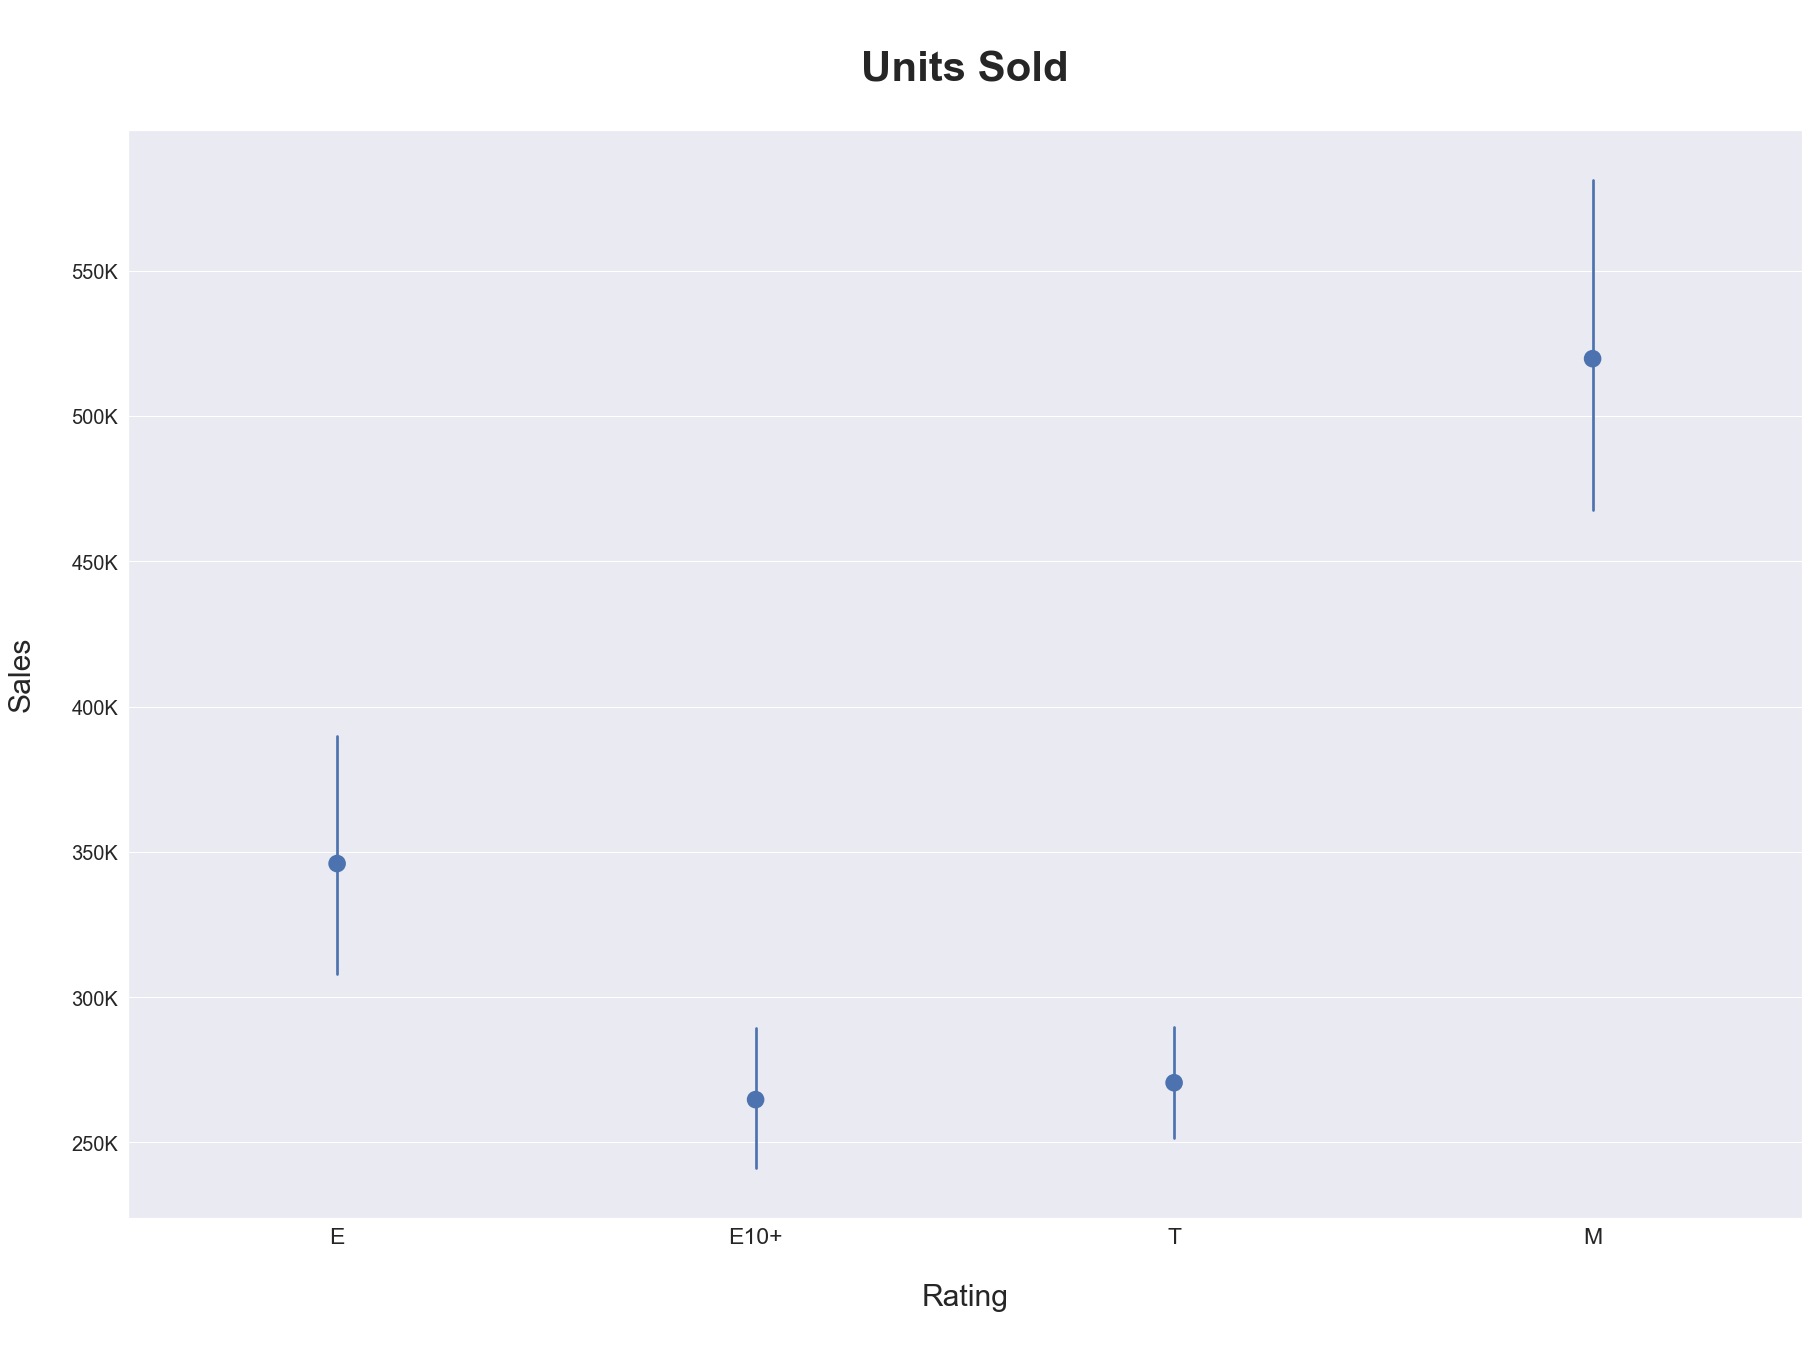

In [106]:
pointplot(
    "Rating",
    "NA_Sales",
    na_sales_e_to_m_since_2003,
    ["E", "E10+", "T", "M"],
)

In [9]:
tukey_rating = pairwise_tukeyhsd(  # Tukey HSD for where I got my following figures from
    endog=na_sales_e_to_m_since_2003["NA_Sales"],  # Data
    groups=na_sales_e_to_m_since_2003["Rating"],  # Groups
    alpha=0.05, # Significance level
)
tukey_rating.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
E,E10+,-0.0812,0.025,-0.1553,-0.0072,True
E,M,0.1737,0.001,0.0993,0.2481,True
E,T,-0.0754,0.011,-0.1382,-0.0126,True
E10+,M,0.255,0.001,0.1671,0.3428,True
E10+,T,0.0058,0.9,-0.0724,0.0841,False
M,T,-0.2491,0.001,-0.3277,-0.1706,True


## With 95% Confidence, M-Rated video games sell more on average than games of another rating

- Between 99k-248k units more than E rated

- 167k-342k more than E10+ rated

- 170k-327k more than T rated

## On Average, Mature Rated Games Sell Better...

## But in what Genres?

In [10]:
print(
    na_sales_e_to_m_since_2003["NA_Sales"]
    .loc[na_sales_e_to_m_since_2003["Rating"] == "M"]
    .groupby(na_sales_e_to_m_since_2003["Genre"])
    .agg("sum")
)

Genre
Action          241.16
Adventure        16.63
Fighting         14.64
Misc              1.92
Platform          0.24
Racing            1.76
Role-Playing     73.29
Shooter         313.89
Simulation        0.67
Sports            2.57
Strategy          2.61
Name: NA_Sales, dtype: float64


## Since 2003 Mature Rated Games sold most in the following genres:

- Shooter: 313 million+

- Action: 241 million+

- Role-Playing: 73 million+

## This seems to go along with intuition...

- But what about how each game sells on average?

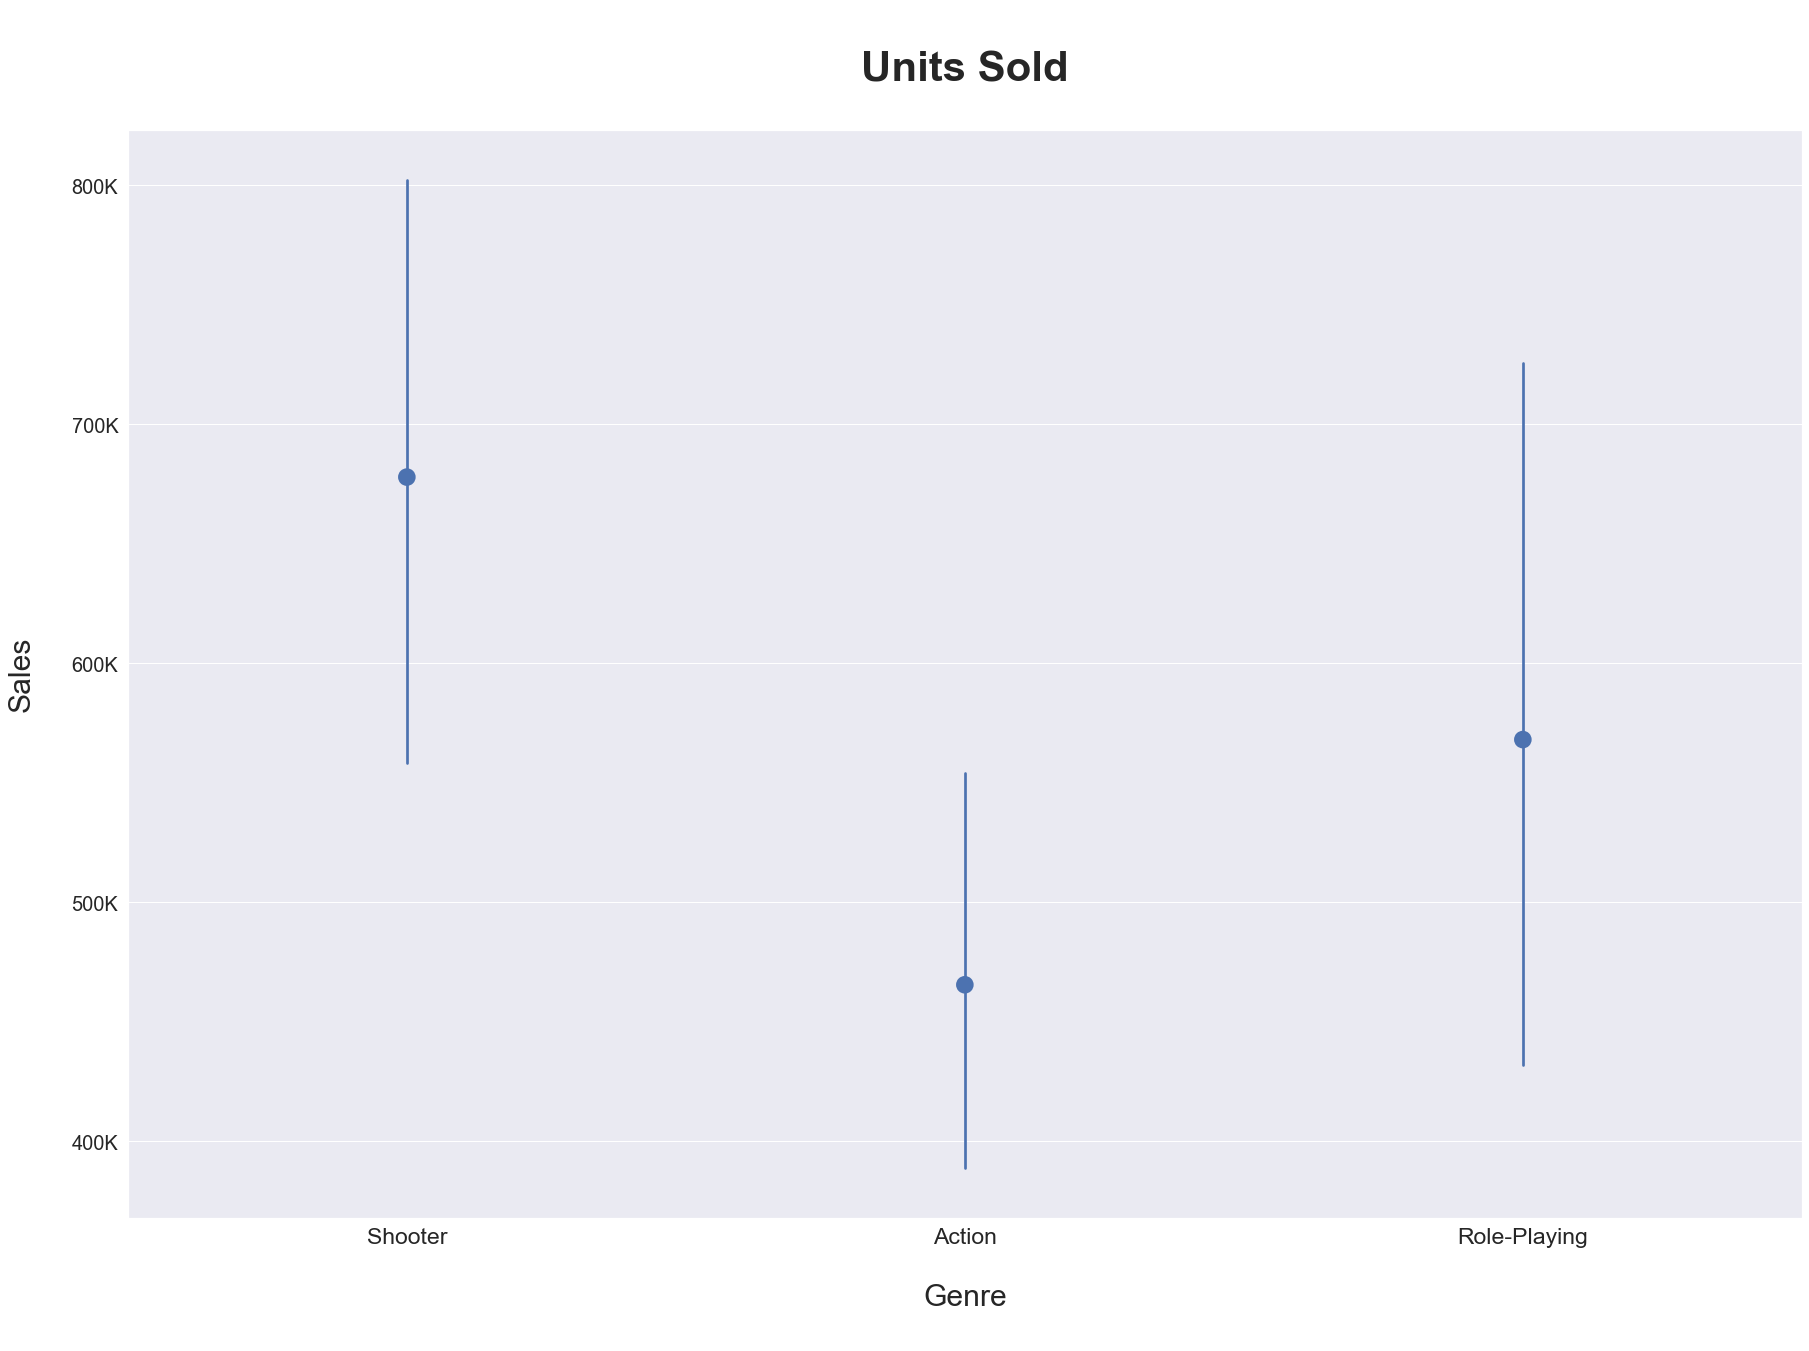

In [107]:
mature = na_sales_e_to_m_since_2003.loc[
    (na_sales_e_to_m_since_2003["Rating"] == "M")
    & (
        (na_sales_e_to_m_since_2003["Genre"] == "Shooter")
        | (na_sales_e_to_m_since_2003["Genre"] == "Action")
        | (na_sales_e_to_m_since_2003["Genre"] == "Role-Playing")
    ),
    ["NA_Sales", "Genre"],
]
pointplot(
    xarray="Genre",
    yarray="NA_Sales",
    df=mature,
    xorder=["Shooter", "Action", "Role-Playing"],
)

- No surprise with Shooters, but Role-Playing games?

- Looks can be deceiving...

## M-Rated Role-Playing games compared to Shooter and Action games

In [12]:
stats.median_test(
    mature["NA_Sales"].loc[mature["Genre"] == "Shooter"],
    mature["NA_Sales"].loc[mature["Genre"] == "Action"],
    mature["NA_Sales"].loc[mature["Genre"] == "Role-Playing"],
)

(4.240676658052763, 0.1199910251964748, 0.19, array([[245, 240,  64],
        [218, 278,  65]], dtype=int64))

In [13]:
stats.kruskal(
    mature["NA_Sales"].loc[mature["Genre"] == "Shooter"],
    mature["NA_Sales"].loc[mature["Genre"] == "Action"],
    mature["NA_Sales"].loc[mature["Genre"] == "Role-Playing"],
)

KruskalResult(statistic=4.799639238651511, pvalue=0.0907343185309352)

## Descriptive statistics shows:

- There is no significant difference in each game's sale on average when comparing all three groups

- This is due to the inclusion of Role-Playing games in the comparison, as Mature rated RPG's generally have Action and/or Shooter elements, probably contributing to this lack of differences in average sales.

## M-Rated Shooters compared to Action games

In [111]:
tukey_mature = pairwise_tukeyhsd(
    endog=mature["NA_Sales"],  # Data
    groups=mature["Genre"],  # Groups
    alpha=0.05, # Significance level
)
tukey_mature.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Role-Playing,0.1026,0.6118,-0.1563,0.3615,False
Action,Shooter,0.2124,0.0088,0.0441,0.3807,True
Role-Playing,Shooter,0.1098,0.5809,-0.1522,0.3718,False


- That's another story

In [14]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = np.sqrt(
        (sample_1_var / sample_1_n)
        + (sample_2_var / sample_2_n)
    )
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return (
        "The difference in means at the 95% confidence interval (two-tail) is between {} and {}.".format(
            ci_lower, 
            ci_upper,
        )
    )
get_95_ci(
    mature["NA_Sales"].loc[mature["Genre"] == "Action"],
    mature["NA_Sales"].loc[mature["Genre"] == "Shooter"],
)

'The difference in means at the 95% confidence interval (two-tail) is between 0.06532778637675712 and 0.3594488507972881.'

- With 95% confidence, M-Rated Shooters sell between 65k+ and 359k+ more units on average

## Why are M-Rated Shooters More Successful than Action games?

- Action games have a lot more titles in other ratings

- It is harder for a Shooter to be successful if it is not M-Rated

## In Conclusion

- Mature Rated Video Games are a safer investment of capital and development time

- More specifically, Shooters sell better on average than Action games if M-Rated

- M-Rated Role-Playing games are a smaller (potentially newer) market, but promising

- Success depends on other factors, such as developer talent, and effective marketing

## Questions?